In [24]:
from os import listdir
from os.path import isfile,join

import numpy as np
from scipy import signal
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import keras
from keras import Sequential,Model,layers
from keras.models import load_model
from sklearn.model_selection import train_test_split

##### A simple way to solve this problem is using classical digital image processing technique called median filtering

In [4]:
class Denoiser:
    
    def __init__(self):
        self.input_image=None
        self.output_image=None
        
    def load_image(self,path):
        return np.asarray(Image.open(path))/255.0
    
    def save_image(self,dest_path,image):
        img_arr=np.asarray(image*255.0,dtype=np.uint8)
        Image.fromarray(img_arr).save(dest_path)
        
    def denoiser_pipeline(self,image):
        background=signal.medfilt2d(image,11)
        
        foreground_mask=image<background-0.1
        
        output_image=np.where(foreground_mask,0.0,1.0)
        
        return output_image
        
    def clean(self,image_path,dest_path):
        self.input_image=self.load_image(image_path)
        
        self.output_image=self.denoiser_pipeline(self.input_image)
        
        self.save_image(dest_path,self.output_image)
        
    
    def show(self):
        
        in_img=np.asarray(self.input_image*255.0, dtype=np.uint8)
        out_img=np.asarray(self.output_image*255.0,dtype=np.uint8)
        
        fig,axs=plt.subplots(1,2,figsize=(16,16))
        axs[0].imshow(Image.fromarray(in_img),cmap='gray')
        axs[1].imshow(Image.fromarray(out_img),cmap='gray')
        axs[0].axis("off")
        axs[1].axis("off")
        plt.show()

In [5]:
input_datapath='train/'
output_datapath='output_median/'

files=[f for f in listdir (input_datapath) if isfile(join(input_datapath,f))]

denoiser=Denoiser()

for f in files:
    
    denoiser.clean(input_datapath+f,output_datapath+f)

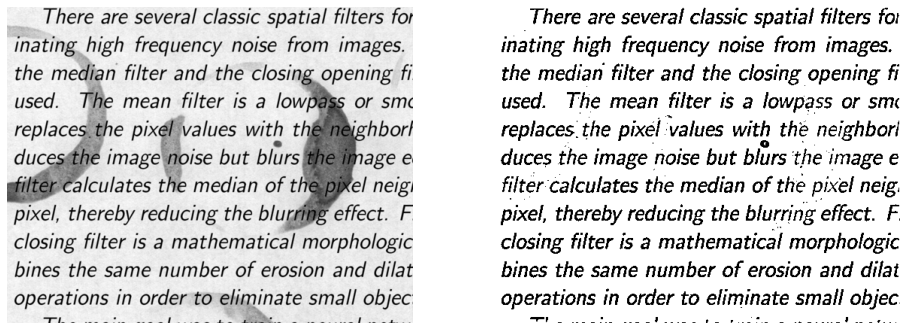

In [6]:
denoiser.show()

In [7]:
def preprocess_image(path):
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img=np.asarray(img,dtype="float32")
    img=cv2.resize(img,(540,420))
    
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img/255.0
    
    img=np.reshape(img,(420,540,1))
    
    return img

In [8]:
noisy_path='train/'
clean_path='train_cleaned/'
test_path='test/'

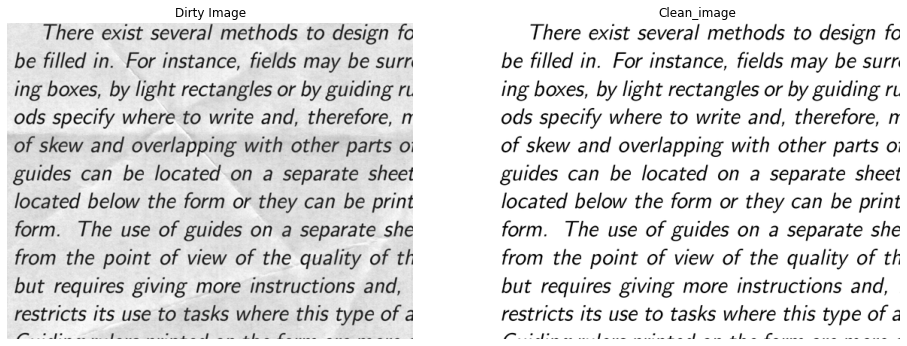

In [9]:
noisy_dir=listdir(noisy_path)

x_paths=[noisy_path+x for x in noisy_dir]

clean_dir=listdir(clean_path)

y_paths=[clean_path+y for y in clean_dir]

size=(420,540)

X=[]
Y=[]

for img in x_paths:
    
    img=preprocess_image(img)
    X.append(img)
    
for label in y_paths:
    
    img=preprocess_image(label)
    Y.append(img)
    
X=np.array(X)
Y=np.array(Y)

fig,axs=plt.subplots(1,2,figsize=(16,16))

axs[0].set_title('Dirty Image')
axs[0].imshow(X[0][:,:,0],cmap='gray')
axs[0].axis("off")

axs[1].set_title('Clean_image')
axs[1].imshow(Y[0][:,:,0],cmap='gray')
axs[1].axis("off")
plt.show()


In [10]:
def autoencoder():
    
    
    input_layer = layers.Input(shape=(420,540,1), name= 'Image_Input')
    
    # Encoder
    
    x = layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_1')(input_layer)
    x = layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_2')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((2,2), padding = 'same', name='Pooling_Layer_3')(x)
    
    
    # Decoder
    x = layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_5')(x)
    x = layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', name = 'Convolutional_Layer_6')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D((2,2), name = 'UpSampling_Layer_3')(x)
    
    output_layer = layers.Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same', name = 'Convolutional_Layer_7')(x)
    
    # Model
    
    autoencoder = Model(inputs = [input_layer], outputs = [output_layer])
    autoencoder.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mae'])
    
    return autoencoder

In [11]:
ae = autoencoder()
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Convolutional_Layer_1 (Conv2 (None, 420, 540, 32)      320       
_________________________________________________________________
Convolutional_Layer_2 (Conv2 (None, 420, 540, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 64)      256       
_________________________________________________________________
Pooling_Layer_3 (MaxPooling2 (None, 210, 270, 64)      0         
_________________________________________________________________
Convolutional_Layer_5 (Conv2 (None, 210, 270, 64)      36928     
_________________________________________________________________
Convolutional_Layer_6 (Conv2 (None, 210, 270, 32)      18464 

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=0)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [15]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

hist = ae.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_valid, y_valid), callbacks = [callback])

Epoch 1/50
65/65 [==============================] - 191s 3s/step - loss: 0.1085 - mae: 0.2577 - val_loss: 0.0766 - val_mae: 0.2462
Epoch 2/50
65/65 [==============================] - 229s 4s/step - loss: 0.0247 - mae: 0.1058 - val_loss: 0.0618 - val_mae: 0.1632
Epoch 3/50
65/65 [==============================] - 219s 3s/step - loss: 0.0118 - mae: 0.0741 - val_loss: 0.0574 - val_mae: 0.1401
Epoch 4/50
65/65 [==============================] - 209s 3s/step - loss: 0.0067 - mae: 0.0535 - val_loss: 0.0438 - val_mae: 0.1249
Epoch 5/50
65/65 [==============================] - 207s 3s/step - loss: 0.0047 - mae: 0.0453 - val_loss: 0.0421 - val_mae: 0.1028
Epoch 6/50
65/65 [==============================] - 209s 3s/step - loss: 0.0030 - mae: 0.0387 - val_loss: 0.0323 - val_mae: 0.0827
Epoch 7/50
65/65 [==============================] - 227s 3s/step - loss: 0.0025 - mae: 0.0314 - val_loss: 0.0232 - val_mae: 0.0747
Epoch 8/50
65/65 [==============================] - 327s 5s/step - loss: 0.0021 - m

In [20]:
ae.save('./model_weights/model_.h5')

In [25]:
ae = load_model("./model_weights/model_.h5")

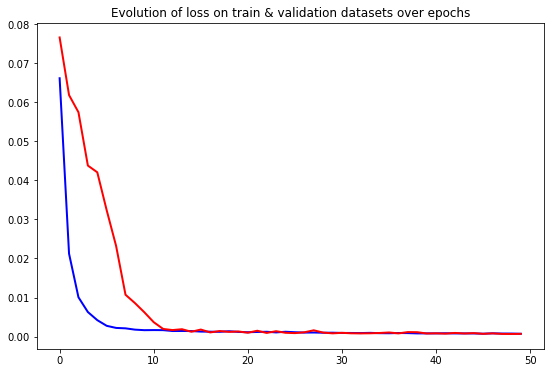

In [26]:
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']


plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')

plt.show()

In [27]:
test_path = 'test/'
test_dir = listdir(test_path)
test_paths = [test_path+x for x in test_dir]

X_test = []
for image in test_paths:
    
    img = preprocess_image(image)
    X_test.append(img)
    
X_test = np.array(X_test)
print(X_test.shape)

(72, 420, 540, 1)


In [41]:
Y_test = ae.predict(X_test, batch_size=1)

In [42]:
print(Y_test[0].shape)

(420, 540, 1)


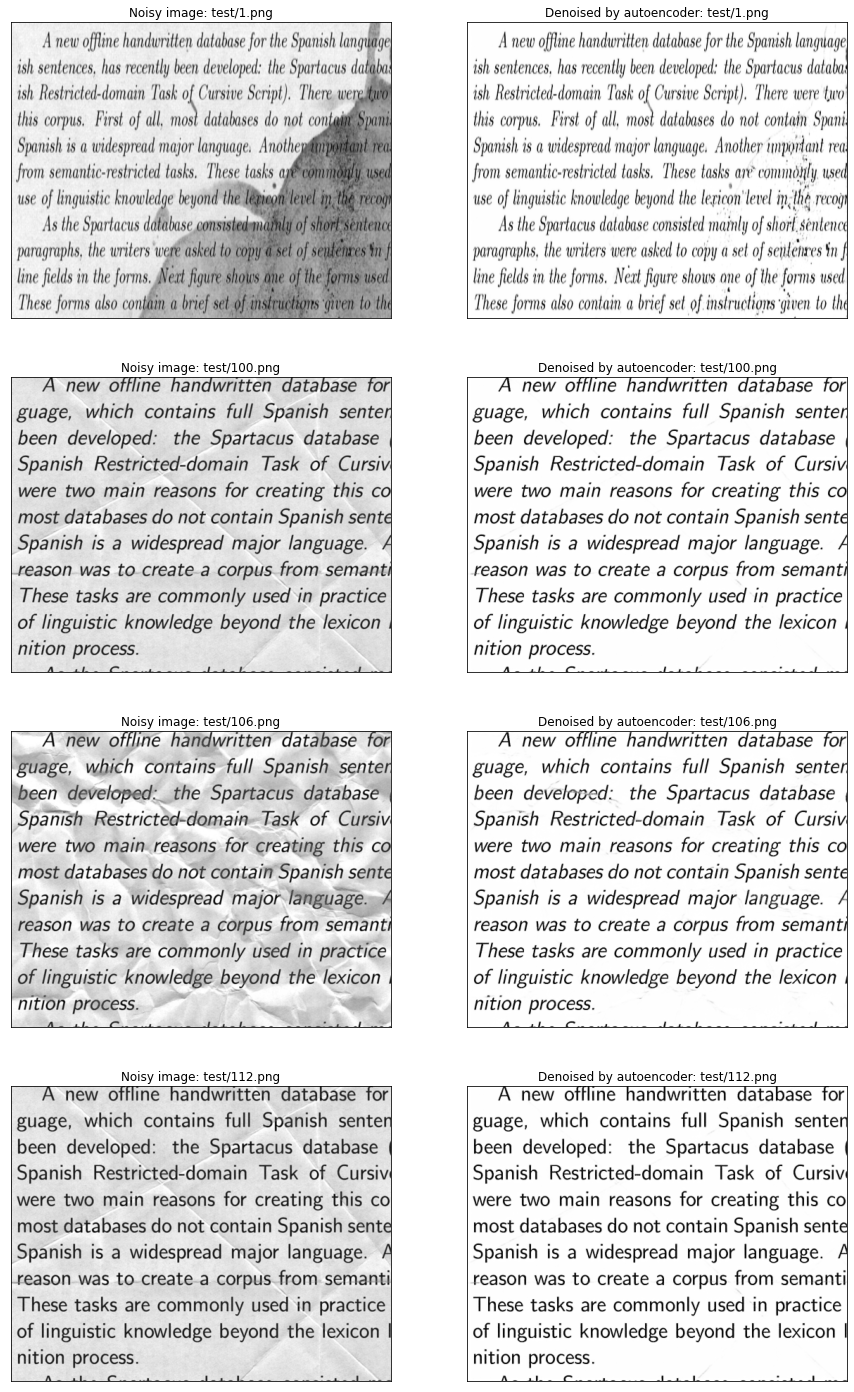

In [43]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_paths[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0],cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_paths[i]))

plt.show()